
# Week 2 — Baseline Prediction Models & Evaluation

In this notebook, you will build **baseline prediction models** for financial
returns and evaluate them using **strictly forward-looking (time-series)
validation**.

This week focuses on **evaluation discipline**, not on maximizing performance.


## 1. Imports

In [14]:

import yfinance as yf
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import scipy.stats as st
%matplotlib inline
plt.style.use("seaborn-v0_8-talk")
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3
plt.rcParams["axes.edgecolor"] = "0.3"
plt.rcParams["axes.linewidth"] = 0.8
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

plt.style.use("seaborn-v0_8")



## 2. Load data from Week 1

- Reuse the data you created in Week 1.
- You can use one stock of your choice (you can repeat it for multiple stocks if you want and plot them separately)
- Take a long term horizon data set (5-10 years)


In [15]:

tickers=["AAPL","MSFT","GOOG","AMZN","TSLA","NVDA"]
data_long=yf.download(tickers,start="2015-01-01", end="2024-01-01",auto_adjust=False)
data_med=yf.download(tickers,start="2020-01-01",end="2024-01-01",auto_adjust=False)
df_long_aapl=data_long['Adj Close']['AAPL'].ffill().bfill()
df_aapl=data_long.swaplevel(axis=1)['AAPL']

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  6 of 6 completed



## 3. Feature construction

Required features:
- $r_t$
- $r_{t-1}$
- 20-day rolling mean
- 20-day rolling volatility
- 5-day momentum


In [34]:
r_t=np.log(df_long_aapl).diff().dropna()
r_t_minus=r_t.shift(1).dropna()
rolling_20_mean=r_t.rolling(20).mean().shift(1).dropna()
rolling_20_vol=r_t.rolling(20).std().shift(1).dropna()
moment_20=r_t.rolling(5).mean().shift(1).dropna()


## 4. Naive baselines


In [35]:
y=r_t.shift(-1).dropna()
y_pred_zero=pd.Series(0.0,index=y.index)

In [36]:
y_pred_roll=r_t.rolling(20).mean().shift(1).loc[y.index]


## 5. Linear models (OLS & Ridge)
Suggested that you review basic linear regression theory as well (resources given in README).

In [37]:
linear_model=LinearRegression()
X_train=pd.concat([r_t,r_t_minus,rolling_20_mean,rolling_20_vol,moment_20],axis=1)
X_train.columns=["r_t","r_t-1","mean_20","vol_20","moment_5"]
ols_data=X_train.join(y).dropna()
X_train=ols_data[X_train.columns]
y_ols=ols_data[y.name]


## 6. Tree-based model (Random Forest) (optional)


In [38]:

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=50,
    random_state=42
)


## 7. Walk-forward evaluation

- Scikit reference for [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In [58]:

# TODO: implement TimeSeriesSplit evaluation
tscv=TimeSeriesSplit()
y_pred_linear_reg=pd.Series(index=y.index,dtype=float)
for train_index,test_index in tscv.split(X_train):
    X_train_i=X_train.iloc[train_index]
    X_test_i=X_train.iloc[test_index]
    model=LinearRegression()
    model.fit(X_train_i,y.iloc[train_index])
    y_pred_linear_reg.iloc[test_index]=model.predict(X_train.iloc[test_index])

tscv_rf=TimeSeriesSplit()
y_pred_rf=pd.Series(index=y.index,dtype=float)
for train_index,test_index in tscv_rf.split(X_train):
    X_train_i=X_train.iloc[train_index]
    X_test_i=X_train.iloc[test_index]
    model=RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        min_samples_leaf=50,
        random_state=42
    )
    model.fit(X_train_i,y.iloc[train_index])
    y_pred_rf.iloc[test_index]=model.predict(X_train.iloc[test_index])


## 8. Prediction accuracy


In [59]:

# TODO: compute RMSE for all models and compare them
zero_rmse=np.sqrt(mean_squared_error(y_pred_zero,y))
roll_rmse=np.sqrt(mean_squared_error(y_pred_roll.iloc[20:],y.iloc[20:]))
mask=~y_pred_linear_reg.isna()
linear_rmse=np.sqrt(mean_squared_error(y_pred_linear_reg[mask],y[mask]))
mask_rf=~y_pred_rf.isna()
rf_rmse=np.sqrt(mean_squared_error(y_pred_rf[mask_rf],y[mask_rf]))
print("RMSE (Zero):", zero_rmse)
print("RMSE (Rolling):", roll_rmse)
print("RMSE (Linear, WF):", linear_rmse)
print("RMSE (rf):", rf_rmse)

RMSE (Zero): 0.018312476322958113
RMSE (Rolling): 0.01854733467930975
RMSE (Linear, WF): 0.01815155234539964
RMSE (rf): 0.018191243703029446


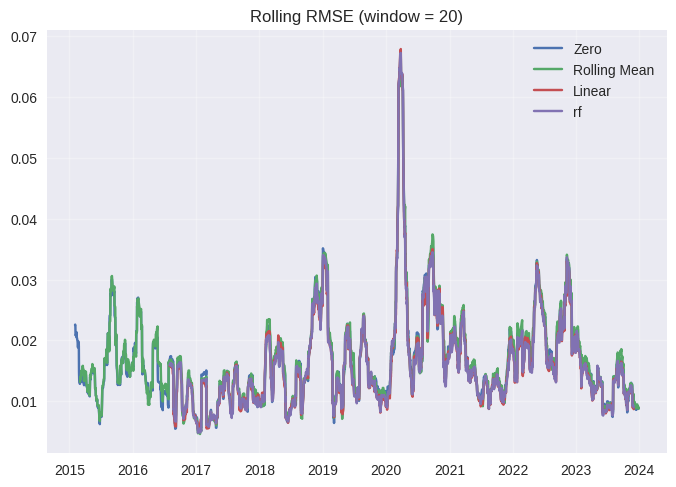

In [61]:
# TODO: plot rolling RMSE vs time for all models to compare their performance across different time periods/regimes
zero_se=(y-y_pred_zero)**2
roll_se=(y.iloc[20:]-y_pred_roll.iloc[20:])**2
linear_se=(y[mask]-y_pred_linear_reg[mask])**2
rf_se=(y[mask_rf]-y_pred_rf[mask])**2
rmse_zero_roll=np.sqrt(zero_se.rolling(20).mean())
rmse_roll_roll=np.sqrt(roll_se.rolling(20).mean())
rmse_linear_roll=np.sqrt(linear_se.rolling(20).mean())
rmse_rf_roll=np.sqrt(rf_se.rolling(20).mean())

plt.plot(rmse_zero_roll,label="Zero")
plt.plot(rmse_roll_roll,label="Rolling Mean")
plt.plot(rmse_linear_roll,label="Linear")
plt.plot(rmse_rf_roll,label="rf")
plt.title(f"Rolling RMSE (window = {20})")
plt.legend()
plt.show()

In [63]:
# Bonus: compute volatility scaled/normalized prediction error: sqrt( ((y_true - y_pred)**2) / (vol_t**2) ) - and compare across models
vol_er_zero=np.sqrt((y[20:]-y_pred_zero[20:])**2/(rolling_20_vol**2))
vol_er_roll=np.sqrt((y[20:]-y_pred_roll[20:])**2/(rolling_20_vol.iloc[20:]**2))
vol_er_linear=np.sqrt((y[mask]-y_pred_linear_reg[mask])**2/(rolling_20_vol.loc[y[mask].index]**2))
vol_er_rf=np.sqrt((y[mask_rf]-y_pred_rf[mask_rf])**2/(rolling_20_vol.loc[y[mask_rf].index]**2))
print("Vol-scaled error (Zero):", vol_er_zero.mean())
print("Vol-scaled error (Rolling):", vol_er_roll.mean())
print("Vol-scaled error (Linear):", vol_er_linear.mean())
print("Vol-scaled error (rf):", vol_er_rf.mean())

Vol-scaled error (Zero): 0.8185249539762955
Vol-scaled error (Rolling): 0.8425389556369847
Vol-scaled error (Linear): 0.8065475603056903
Vol-scaled error (rf): 0.8061007767576055


## 9. Bonus: Looking at a toy strategy based on predictions
Define a simple "all-in" strategy where you go all long (+1) when you predict the stock to be going up, and all short (-1) when you predict the stock to be going down
$$
\text{position}_t = \text{sign}(y_\text{pred})
$$
Then, your returns for the $t$-th day (assuming daily returns) will be $(\text{position}_t \times y_\text{true})$ (note $y_\text{true} = r_t$).

Note that this is extremely simplistic and ignore any predictions related magnitude of expected returns, or expected volatility data etc. It is used only as a demonstration of what a prediction-based strategy may look like.

**Plot your returns using this strategy based on all the models above and compare them!**

In [67]:
# TODO: compute the positions for each model and daily returns
zero_pos=np.sign(y_pred_zero)
roll_pos=np.sign(y_pred_roll[20:])
linear_pos=np.sign(y_pred_linear_reg[mask])
rf_pos=np.sign(y_pred_rf[mask_rf])

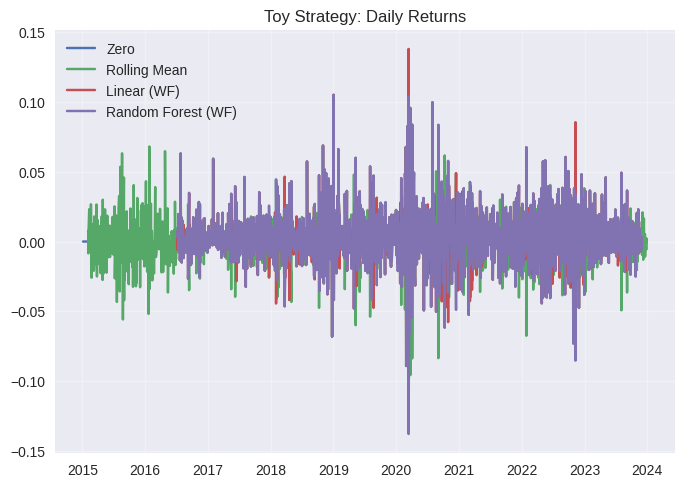

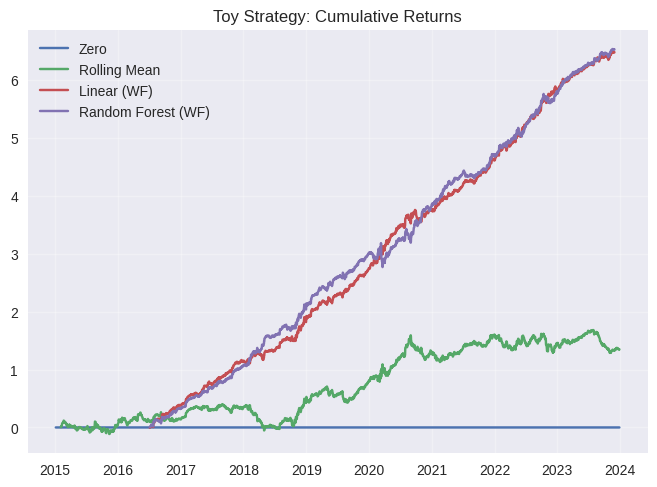

In [71]:
# TODO: plot your returns
pos_zero=zero_pos*y
pos_roll=roll_pos*y[20:]
pos_linear=linear_pos*y[mask]
pos_rf=rf_pos*y[mask_rf]

plt.plot(pos_zero, label="Zero")
plt.plot(pos_roll, label="Rolling Mean")
plt.plot(pos_linear, label="Linear (WF)")
plt.plot(pos_rf, label="Random Forest (WF)")

plt.title("Toy Strategy: Daily Returns")
plt.legend()
plt.show()


plt.plot(pos_zero.cumsum(), label="Zero")
plt.plot(pos_roll.cumsum(), label="Rolling Mean")
plt.plot(pos_linear.cumsum(), label="Linear (WF)")
plt.plot(pos_rf.cumsum(), label="Random Forest (WF)")

plt.title("Toy Strategy: Cumulative Returns")
plt.legend()
plt.show()




## 10. Discussion questions

1. Why do we need naive baselines?
2. How does the evaluation strategy here (walk-forward evaluation) differ from the random training-test dataset splits used in convention ML?
3. *(Addon)* And, why does random splitting technique fail here?
4. Interpret the RMSE values and rolling RMSE plot results very briefly.
5. *(Addon)* Are there periods where model performance degrades noticeably? What might this indicate?
6. Why might Random Forest overfit?
7. *(Bonus)* Two models have similar RMSE, but one makes larger errors primarily during high-volatility periods. Why might this model be *less dangerous* in a portfolio context?


## 10. Discussion questions

1. Why do we need naive baselines?
2. How does the evaluation strategy here (walk-forward evaluation) differ from the random training-test dataset splits used in convention ML?
3. *(Addon)* And, why does random splitting technique fail here?
4. Interpret the RMSE values and rolling RMSE plot results very briefly.
5. *(Addon)* Are there periods where model performance degrades noticeably? What might this indicate?
6. Why might Random Forest overfit?
7. *(Bonus)* Two models have similar RMSE, but one makes larger errors primarily during high-volatility periods. Why might this model be *less dangerous* in a portfolio context?